In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns

In [2]:
df0 = pd.read_fwf('PCC_cat.txt', header=None)
# df0

In [3]:
def checkBalance(df):
    all_labels = df['labels']
    all_labels = all_labels.tolist()
    balance = df['labels'].value_counts()
    print(balance)
    for i in range(len(balance)):
        print(f'{balance[i]*100/df.size:.2f} %')

In [4]:
bright = np.where(df0[4] <= 19.4)
brightDF = df0.iloc[bright].copy()

In [5]:
labels = np.unique(brightDF[21])

# access ra and dec from their columns in the dataframe
names = brightDF[1]
ra = brightDF[2]
dec = brightDF[3]

filenames = []
for r, d in zip(ra, dec):
    fn = f'sdss_ra={r}_dec={d}.png'
    filenames.append(fn)

brightDF_reduced = pd.DataFrame({'files' : filenames,
                                 'name': names,
                                 'labels': brightDF[21],
                                 'ra':ra,
                                 'dec':dec})

# brightDF_reduced = pd.DataFrame({'name': names,
#                                  'ra':ra,
#                                  'dec':dec})
# brightDF_reduced

In [6]:
# checkBalance(brightDF_reduced)
df1 = brightDF_reduced
unique_labels = np.unique(df1['labels'])

clusterBG_LTG = df1.loc[(df1['labels']==unique_labels[0])]
BG_ETG = df1.loc[(df1['labels']==unique_labels[1])]
clusterBG_edgeDisk = df1.loc[(df1['labels']==unique_labels[2])]
likely_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[3])]
likely_merging = df1.loc[(df1['labels']==unique_labels[4])]
poss_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[5])]
weak_bg = df1.loc[(df1['labels']==unique_labels[6])]

downSampleDf0 = pd.concat([clusterBG_LTG, # 384
                         BG_ETG.sample(frac = 400/3008),
                         clusterBG_edgeDisk.sample(frac = 400/1049),
                         likely_dE_ETGcluster, # 398
                         likely_merging, # 23
                         poss_dE_ETGcluster, # 98
                         weak_bg # 477
                         ])
# checkBalance(downSampleDf0)

def replace(df, ind):
    label = list(df['labels'])[0]
    newDf = df.replace(label, str(ind))
    return(newDf)


# combined 3 and 5
second = pd.concat([
                    replace(likely_dE_ETGcluster, 1), # old 3
                    replace(poss_dE_ETGcluster, 1) # old 5
                    ])
# combine 0,1,2,6
first = pd.concat([replace(clusterBG_LTG, 0), # old 0
                   replace(BG_ETG, 0), # old 1
                   replace(clusterBG_edgeDisk, 0), # old 2
                   replace(weak_bg, 0) # old 6
                    ])

lenSecond = len(second.index)
lenFirst = len(first.index)

downSampleDf1 = pd.concat([first.sample(frac = lenSecond/lenFirst), second])

# 0 is background
# 1 is dE/ETGcluster


# remove red contaminants
downFiles = downSampleDf1['files']
redPercent = [None]*len(downFiles)
counter = 0
workDir = 'SDSS-png/'

# lower boundary RED color range values; Hue (0 - 10)
lower1 = np.array([0, 80, 20])
upper1 = np.array([10, 255, 255])
 
# upper boundary RED color range values; Hue (160 - 180)
lower2 = np.array([160, 100, 20])
upper2 = np.array([179, 255, 255])

for i, x in enumerate(downFiles):
    testImgPath = os.path.join(workDir, x)
    image = cv2.imread(testImgPath)
    result = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower_mask = cv2.inRange(image, lower1, upper1)
    upper_mask = cv2.inRange(image, lower2, upper2)
    full_mask = lower_mask + upper_mask;

    result = cv2.bitwise_and(result, result, mask=full_mask)
    dim = np.shape(full_mask)[0] 
    counts = np.count_nonzero(full_mask)
#     print(counts)
#     print(dim**2)
    percent = 100*counts/dim**2
    redPercent[i] = percent
    subtitle_string = f'{percent}% of the image is red'
    filename = testImgPath.split('\\')[-1]
#     print(f'{filename}, {subtitle_string}')
#     if percent > 50.0:
#         counter += 1
# #         print('To be removed')
#     else:
#         pass

downSampleDf1['reds'] = redPercent # add new column of the red percentage of an image
# downSampleDf1
redList = (downSampleDf1['reds'] >= 50) # percentage threshold of how much red is in the image
# downSampleDf1.shape
df_filtered = downSampleDf1[downSampleDf1['reds'] <= 50]
# df_filtered.shape

In [7]:
df_filtered

df_filtered.to_csv('brightPCC.csv', index = False)


In [8]:
# bright_csv = 'Skyserver_CrossID8_15_2023 6_55_22 AM.csv'
bright_csv = 'Skyserver_CrossID9_1_2023 4_30_45 AM.csv'
brightDF1 = pd.read_csv(bright_csv, skiprows = 1)
brightDF1

,files,name,labels,reds,objID,ra,dec,type,u_g,modelMag_r,g_z,petroRad_r
0,sdss_ra=49.8839_dec=41.7175.png,PCC-4515,0,6.8200,1237670458048446775,49.883902,41.717491,GALAXY,2.124285,19.11043,1.930006,2.624102
1,sdss_ra=49.3925_dec=41.5647.png,PCC-0870,0,1.2650,1237661055281661796,49.392493,41.564696,GALAXY,1.545128,19.34463,1.360119,7.358008
2,sdss_ra=49.5539_dec=41.502.png,PCC-1867,0,10.2025,1237661055281662248,49.553932,41.502013,GALAXY,5.081095,19.56563,1.893360,3.664067
3,sdss_ra=49.6184_dec=41.4546.png,PCC-2341,0,1.7125,1237661055281726881,49.618438,41.454555,GALAXY,1.717859,18.95229,2.589348,2.714802
4,sdss_ra=49.5268_dec=41.3295.png,PCC-1707,0,6.0975,1237661083199145265,49.526844,41.329527,GALAXY,1.152348,18.77175,0.805294,3.169831
...,...,...,...,...,...,...,...,...,...,...,...,...
209,sdss_ra=49.9756_dec=41.3089.png,PCC-5196,1,11.9175,1237661055281856865,49.973889,41.305407,STAR,-0.215532,22.86876,3.937397,0.908567
210,sdss_ra=49.9947_dec=41.75.png,PCC-5358,1,49.0425,1237670960021504409,49.994725,41.750034,GALAXY,6.157221,17.53399,1.576391,8.789475
211,sdss_ra=49.9967_dec=41.3092.png,PCC-5374,1,17.3550,1237661055281857031,49.996200,41.309363,STAR,1.041622,22.91631,1.991064,1.055185
212,sdss_ra=49.8825_dec=41.7447.png,PCC-4502,1,4.6300,1237670458048446875,49.882513,41.744532,GALAXY,3.955753,19.29449,-0.534899,7.691484


In [9]:
# '''
# df = pd.DataFrame({'A': range(1, 6),
#                    'B': range(10, 0, -2),
#                    'C C': range(10, 5, -1)})
                   
                   
                   
                   
# display(dataFrame.loc[(dataFrame['Salary']>=100000) & (dataFrame['Age']< 40) & (dataFrame['JOB'].str.startswith('D')),
#                     ['Name','JOB']])
#                    '''


In [10]:
# brightDF2 = display(brightDF1.loc[(brightDF1['modelMag_r'] < 17.3) & (brightDF1['u_g'] < 2.5)])
brightDF2 = brightDF1.loc[(brightDF1['modelMag_r'] < 17.3) \
                          & (brightDF1['u_g'] < 2.5) \
                          & (brightDF1['g_z'] < 2.2)]

pairDf = brightDF2[['u_g', 'g_z','modelMag_r','petroRad_r','labels']]
pairDf

,u_g,g_z,modelMag_r,petroRad_r,labels
11,1.836525,1.359153,16.44724,9.588817,0
16,1.719509,1.819835,16.58471,6.976413,0
26,1.635536,1.695250,17.08435,10.597430,0
116,1.979811,1.777552,17.19889,4.434128,1
117,1.915014,1.519541,16.79855,9.303005,1
119,1.899044,1.712949,14.84952,9.490194,1
120,1.909660,1.748759,15.46424,9.336884,1
124,1.995680,1.744754,14.76266,10.141580,1
133,1.815702,1.647505,16.05032,7.688799,1
136,2.152695,1.878805,16.70314,4.110968,1


In [11]:

# brightDF2 = brightDF1.query('modelMag_r < 17.3')
# brightDF3 = brightDF2.query('u_g < 2.5')
# brightDF3

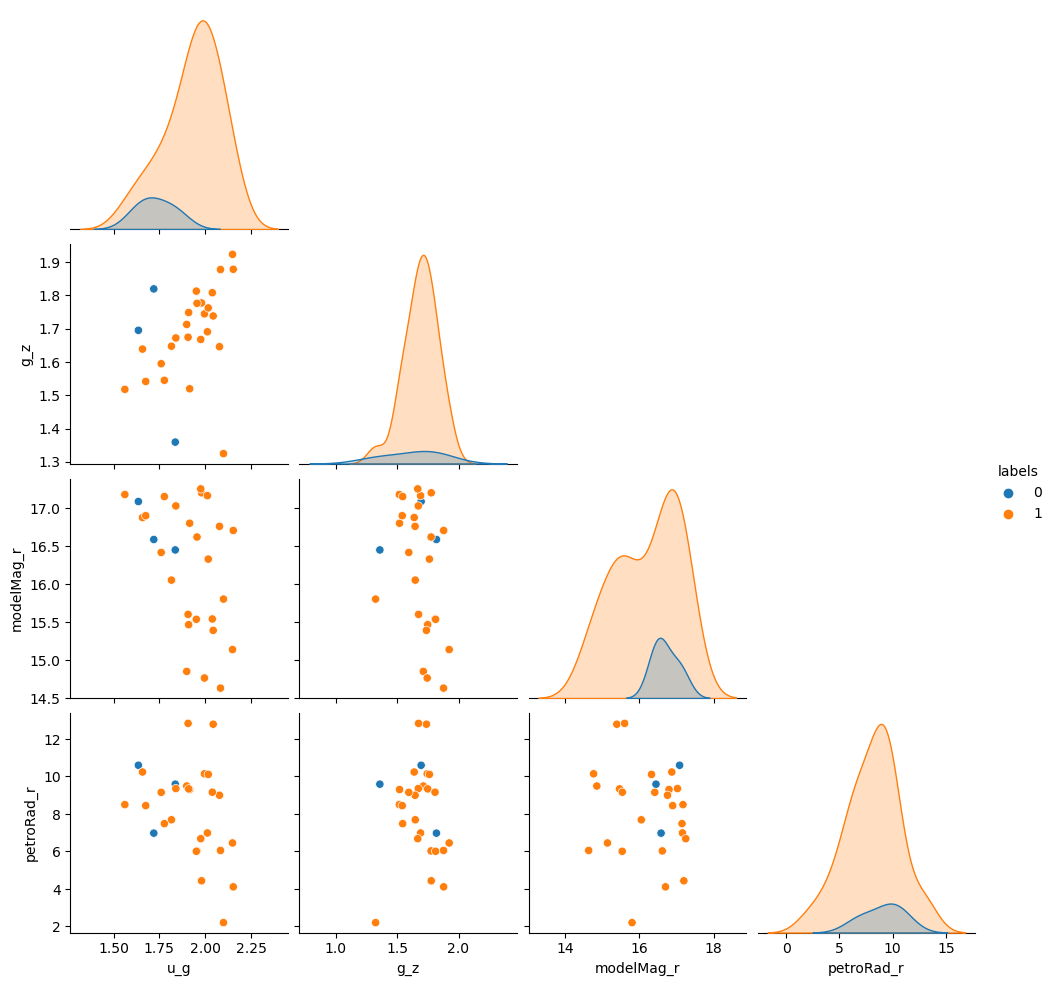

In [12]:
# brightPair = 
p1 = sns.pairplot(pairDf, corner = True, hue = 'labels')


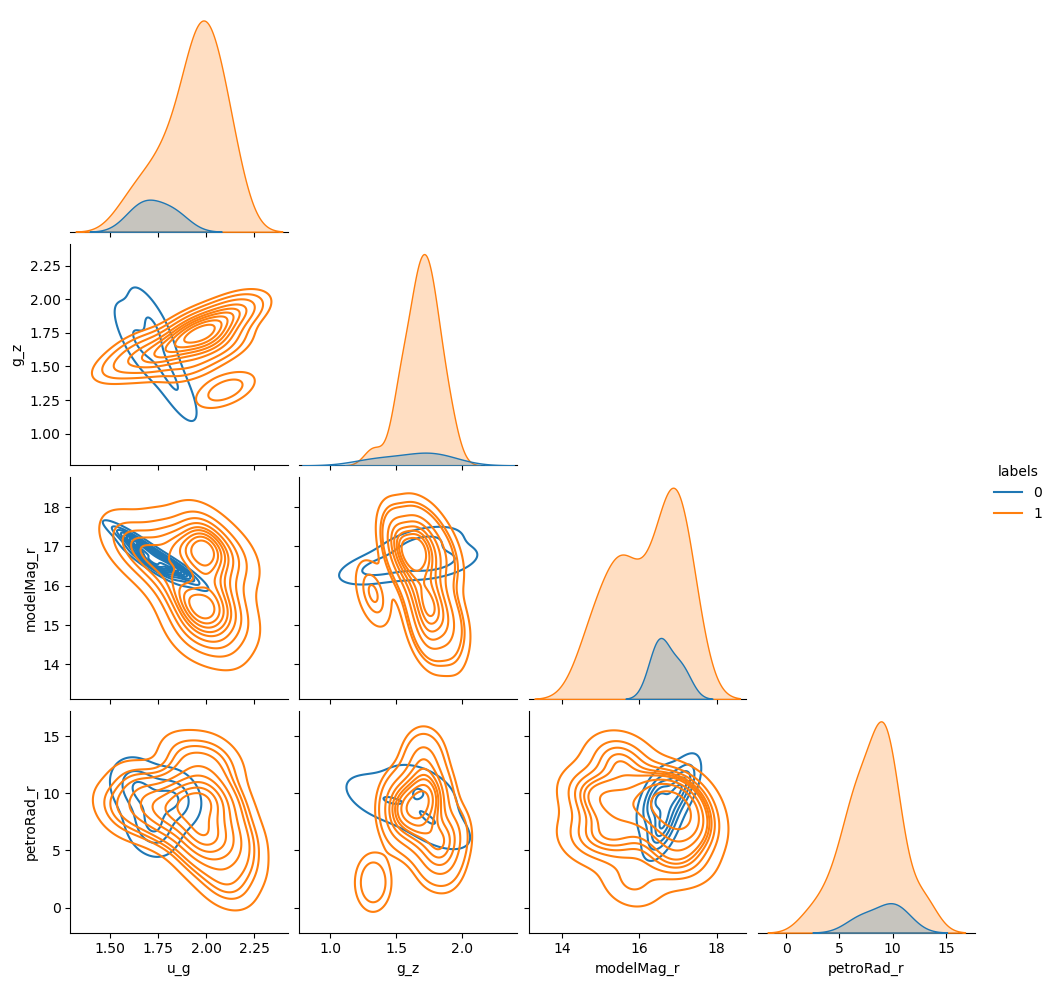

In [13]:
p2 = sns.pairplot(pairDf, hue = 'labels', corner = True, kind = 'kde')